In [2]:
import os
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

In [75]:
max_sequence = 9
blank_num = -1
characters_0 = '0123456789'
characters_alphabet = 'ABCDEFGHIJKLMNPQRSTUVWXYZ-'
characters_1 = '가나다라마바사아자하거너더러머버서어저허고노도로모보소오조호구누두루무부수우주'
characters_1d = 'GNDLMBSOJHgndlmbsojhgNDLMBSOJHGNDLMBSUJ'
characters_2 = '대배해제기교표외인천국합육공영준협정울경강원충북운남전산광'
characters_2d = 'DBHJGGPYICGHUGYJHJUGKWCBUNJSG'
characters_3 = '_       abcd  '
plate_characters = characters_0 + characters_alphabet + characters_1 + characters_2 + characters_3
num_classes = len(plate_characters)
print('num_classes', num_classes)

num_classes 118


In [76]:
folder_Kar = '/home/mvlab/Downloads/dataset/KarPlate'
SUBSET_LPR = 'Subset LPR'
SUBSET_LPD = 'Subset LPD'
TYPE_REAL_CAR = 0

folder_Kar_recog = folder_Kar + os.sep + SUBSET_LPR
os.path.isdir(folder_Kar_recog)

True

In [77]:
EOS = num_classes - 1
SOS = EOS - 1

In [30]:
np.set_printoptions(precision=3)

In [78]:

def load_kar_path(max_m=100, is_train=True):
    folder_train_or_test = 'train' if is_train else 'test'
    folder_Kar_recog = folder_Kar + os.sep + SUBSET_LPR  + os.sep + folder_train_or_test
    path_annotations = folder_Kar_recog + os.sep + 'annotations' + os.sep
    folder_detect = folder_Kar + os.sep + SUBSET_LPD  + os.sep + folder_train_or_test
    folder_detect_annotation = folder_detect + os.sep + 'annotations' + os.sep

    txt_list = glob(path_annotations + '*.txt')
    txt_list.sort()
    txt_list = txt_list[:max_m]
    txt_list_recog = []
    txt_list_detect = []
    img_path_list = []
    string_list = []
    print('txt len', len(txt_list))
    for i in range(len(txt_list)):

        txt = txt_list[i]
        txt_split = txt.split(os.sep)
        txt_file = txt_split[-1]
        detect_txt = folder_detect_annotation + txt_file

        if not os.path.exists(detect_txt):
            print(i, 'not_exist_detect_txt', detect_txt)
            continue

        txt_list_recog.append(txt)
        txt_file_pre = txt_file.split('.')[0]
        img_file_recog = folder_Kar_recog + os.sep + 'images' + os.sep + txt_file_pre + '.jpg'
        img_file_detect = folder_detect + os.sep + 'images' + os.sep + txt_file_pre + '.jpg'
        img_path_list.append(img_file_detect)
        txt_list_detect.append(detect_txt)
        if not is_train:
            string_path = folder_Kar_recog + os.sep + 'strings' + os.sep + txt_file_pre + '.txt'
            string = np.loadtxt(string_path, dtype='str')
            string_list.append(string)

    return txt_list_detect, txt_list_recog, img_path_list, string_list


def arange_row_2_plate(df):
    df_sort_y = df.sort_values(by='cx')
    cy_diff = df_sort_y['cy'] - df_sort_y.iloc[0]['cy']
    thresh = cy_diff.mean()
    group_0 = cy_diff < thresh
    group_1 = cy_diff > thresh
    df_group_0 = df_sort_y[group_0].sort_values(by='cx')
    df_group_1 = df_sort_y[group_1].sort_values(by='cx')
    df_arrange = pd.concat((df_group_0, df_group_1))
    return df_arrange


def arange_row_1_plate(df):
    df_sort_x = df.sort_values(by='cx')
    return df_sort_x


def reorder_label(label_list, img_path_list, string_list, is_train):
    row_2_list = []
    gt_list = []
    img_list = []
    for i in range(len(label_list)):
        label_path = label_list[i]
        img_path = img_path_list[i]
        string = string_list[i] if len(string_list) > 0 else ''
        df = pd.read_csv(label_path, sep=' ', header=None, skiprows=1)
        if len(df) != 7:
            print('len not 7', len(df), df)
            exit()
        df['cx'] = (df[0] + df[2]) / 2
        df['cy'] = (df[1] + df[3]) / 2
        df['width'] = df[2] - df[0]
        df['height'] = df[3] - df[1]
        width_mean = df['width'].values.min()
        cy_v = df.sort_values(by='cx')['cy'].values
        y_grad = cy_v[1:] - cy_v[:-1]
        is_multi_row = y_grad.std() > width_mean / 2
        if is_multi_row:
            df = arange_row_2_plate(df)
        else:
            df = df.sort_values(by='cx')
        classes = df[4].values
        if classes[0] > 9:
            print('first_class_wrong', classes)
            print(label_path)
            continue
        class_and_bb = df[[4, 0, 1, 2, 3]].values
        class_and_bb = class_and_bb.astype(np.float)
        gt_list.append(class_and_bb)
        img_list.append(img_path)

        char_seq_v = np.take(np.array(list(plate_characters)), classes)
        class_label = ''.join(char_seq_v)
        if string != '' and string != class_label:
            print('parsing fail', i, classes, string, class_label)
            exit()


    print('row_2_list', len(row_2_list))#train 139, test 32
    gt = np.stack(gt_list, 0)
    return img_list, gt


def load_detection_label(img_path_list, cbbox_gt, is_train):
    folder_train_or_test = 'train' if is_train else 'test'
    bbox_list = []
    img_valid_list = []
    for i in range(len(img_path_list)):
        file_name = img_path_list[i].split('/')[-1]
        file_name_pre = file_name.split('.')[0]
        folder_Kar_recog = folder_Kar + os.sep + SUBSET_LPD + os.sep + folder_train_or_test
        bbox_annotation_path = folder_Kar_recog + os.sep + 'annotations' + os.sep + file_name_pre + '.txt'
        #print('path_annotations', bbox_annotation_path)
        if os.path.exists(bbox_annotation_path):
            df = pd.read_csv(bbox_annotation_path, sep=' ', header=None, skiprows=1)
            bbox = df.values
            text = cbbox_gt[i:i+1, :, 0]
            print('load_detection_label', file_name, bbox.shape, text.shape, 'text', text)
            bbox_and_class = np.concatenate((bbox, bbox[:, :1] * 0 + TYPE_REAL_CAR, text), 1)
            # shear-xy
            bbox_and_class = np.concatenate((bbox_and_class, bbox_and_class[:, :2]*0 + EOS), 1)
            bbox_list.append(bbox_and_class)
            img_valid_list.append(img_path_list[i])
        else:
            print('not exist', bbox_annotation_path)
            exit()
    return bbox_list


def shift_class_number(gt):
    print('shift_char_class_number', gt.shape, type(gt))
    gt[:, :, 0] = np.where(gt[:, :, 0] > 9, gt[:, :, 0] + len(plate_characters), gt[:, :, 0])
    gt[:, :, 0] = gt[:, :, 0]# + env.num_0
    return gt


def load_kar(m, is_train):
    txt_list_detect, txt_list_recog, img_path_list, string_list = load_kar_path(m, is_train=is_train)
    img_path_list, gt = reorder_label(txt_list_recog, img_path_list, string_list, is_train=is_train)
    gt = shift_class_number(gt)
    gt_all = load_detection_label(img_path_list, gt, is_train)
    return gt_all, img_path_list

In [88]:
m = 3
labels, img_path_list = load_kar(m, True)
print('img_path_list', len(img_path_list), img_path_list[0])
print('labels', len(labels), labels[0])


txt len 3
row_2_list 0
shift_char_class_number (3, 7, 5) <class 'numpy.ndarray'>
load_detection_label 1.jpg (1, 4) (1, 7) text [[  5.   2. 159.   3.   6.   2.   7.]]
load_detection_label 10.jpg (1, 4) (1, 7) text [[  1.   2. 131.   1.   4.   6.   6.]]
load_detection_label 100.jpg (1, 4) (1, 7) text [[  2.   9. 156.   7.   1.   8.   9.]]
img_path_list 3 /home/mvlab/Downloads/dataset/KarPlate/Subset LPD/train/images/1.jpg
labels 3 [[531. 792. 764. 933.   0.   5.   2. 159.   3.   6.   2.   7. 117. 117.]]


In [89]:
def visualize_plate(
    image, y, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""    
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    
    vertices_norm = y[:8]    
    plate_type = y[8]
    plate_text = y[9:]
    vertices_norm_2d = np.reshape(vertices_norm, [-1, 2])
    vertices_2d = vertices_norm_2d * np.array((img_w, img_h), np.float)
    
    x0, y0, x1, y1, x2, y2, x3, y3 = np.reshape(vertices_2d, [-1])
    
    w, h = x2 - x1, y2 - y1    
    color = [1,0,0]
    linewidth = 10
    plt.plot(x0, y0, x1, y1, 'go-', linewidth=linewidth)
    plt.plot(x1, y1, x2, y2, 'ro--', linewidth=linewidth)
    plt.plot(x2, y2, x3, y3, marker = 'o', linewidth=linewidth)
    plt.plot(x3, y3, x0, y0, marker = 'o', linewidth=linewidth)
        
    txt = str.format('(%d)' % (plate_type)) + str(plate_text)
    ax.text(x0, y0, txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

In [90]:
def convert_box_to_vertex(box):    
    #print('box', box)
    x0, y0, x1, y1 = np.split(box, 4, -1)
    #x0, y0, x1, y1 = list(box)
    vertex = np.concatenate((x0, y0, x1, y0, x1, y1, x0, y1), -1)
    return vertex 

In [96]:
def load_data_kar_plate():
    x_list = []
    y_list = []
    for i in range(len(labels)):
        img_path = img_path_list[i]
        label = labels[i]
        print(i, img_path)
        if os.path.isfile(img_path):
            label = label[0]
            box = label[0:4]
            plate_type = label[4:5]
            plate_text = label[5:]

            img = Image.open(img_path)
            arr = np.array(img)
            img_h, img_w, img_c = arr.shape

            coord_2d = np.reshape(box, [-1, 2])
            coord_2d_norm = coord_2d / (np.array((img_w, img_h), np.float))
            coord_norm = np.reshape(coord_2d_norm, [-1])

            vertex = convert_box_to_vertex(coord_norm)                
            vertex_label = np.concatenate((vertex, plate_type, plate_text), -1)

            x_list.append(arr)
            y_list.append(vertex_label)
            #plt.title(vertex_label)
            #plt.imshow(img)
            #break
        else:
            print('not exist', img_path)

    print(len(x_list), len(y_list))
    return x_list, y_list

In [99]:
kar_x_list, kar_y_list = load_data_kar_plate() load_data_kar_plate()

SyntaxError: invalid syntax (<ipython-input-99-52210e4a25c8>, line 1)

In [92]:
def visualize_plate(
    image, y, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""    
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    
    vertices_norm = y[:8]    
    plate_type = y[8]
    plate_text = y[9:]
    vertices_norm_2d = np.reshape(vertices_norm, [-1, 2])
    vertices_2d = vertices_norm_2d * np.array((img_w, img_h), np.float)
    
    x0, y0, x1, y1, x2, y2, x3, y3 = np.reshape(vertices_2d, [-1])
    
    w, h = x2 - x1, y2 - y1    
    color = [1,0,0]
    linewidth = 10
    plt.plot(x0, y0, x1, y1, 'go-', linewidth=linewidth)
    plt.plot(x1, y1, x2, y2, 'ro--', linewidth=linewidth)
    plt.plot(x2, y2, x3, y3, marker = 'o', linewidth=linewidth)
    plt.plot(x3, y3, x0, y0, marker = 'o', linewidth=linewidth)
        
    txt = str(plate_type) + str(plate_text)
    ax.text(x0, y0, txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

In [93]:
def display_data(X, Y, stride=1):
    for i in range(len(X)):
        if i%stride==0:            
            ax = visualize_plate(X[i], Y[i])

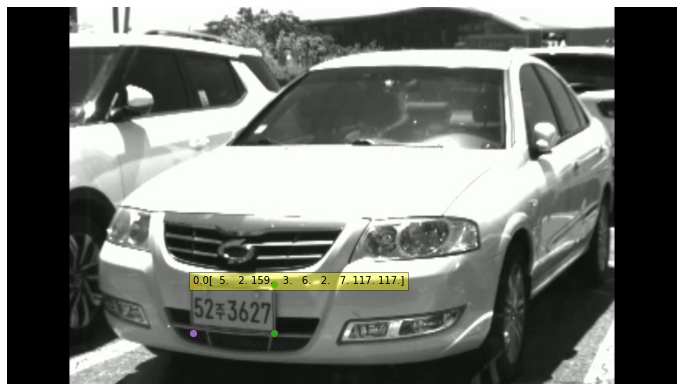

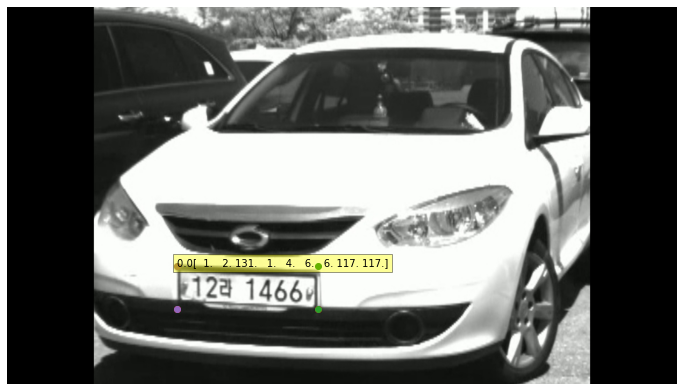

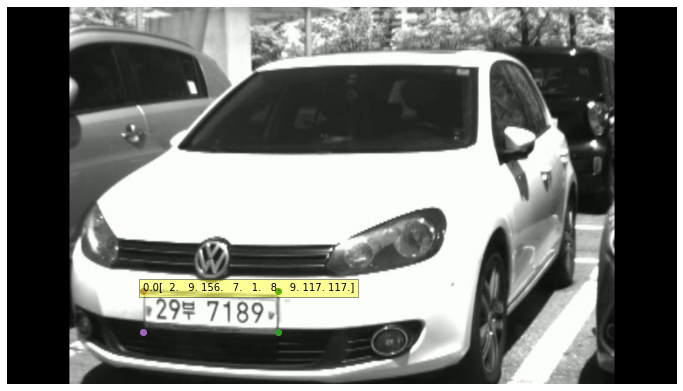

In [98]:
display_data(kar_x_list, kar_y_list)

In [100]:
import tensorflow as tf

In [101]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [102]:
def convert_norm_to_uv(coord):
    return coord * 2 - 1 

def convert_uv_to_norm_to(coord):
    return coord + 1 / 2


def transform_uv(uv, mat):
    #coord : (m, n, 2)
    #theta : (m, 2, 3)    
    inv_mat = tf.linalg.inv(mat)        
    xyo = tf.concat((uv, 1 + 0 * uv[:, :, :1]), -1)
    new_xy = tf.einsum('mrc,msc->mrs', inv_mat, xyo)
    new_xy = tf.transpose(new_xy, [0, 2, 1])
    new_xy = new_xy[:, :, :2]
    return new_xy


def transform_xy(xy, theta):
    m = tf.shape(xy)[0]
    theta = tf.linalg.inv(theta)
    theta = theta[:, :2]
    # xy [0, 1] > [-1, 1]
    xy = (xy - 0.5) * 2
    theta = tf.reshape(theta, [-1, 2, 3])
    xy = tf.reshape(xy, [m, -1, 2])
    xyo = tf.concat((xy, 1 + 0 * xy[:, :, :1]), -1)
    new_xy = tf.einsum('mrc,msc->mrs', theta, xyo)
    new_xy = tf.transpose(new_xy, [0, 2, 1])

    return new_xy

In [103]:

def get_x1(t1, t2, width, height):
    a = tf.sign(t2) * width - height * tf.sin(t2)/tf.cos(t2)
    b = (tf.sign(t2) * tf.cos(t1) * tf.cos(t2) - tf.sign(t1) * tf.sin(t1) * tf.sin(t2)) / (tf.cos(t1)*tf.cos(t2))
    x1 = a / b
    return x1

def get_v1_v2(t1, t2, width, height):
    x1 = get_x1(t1, t2, width, height)
    #x1 = get_x1_new(t1, t2, width, height)
    y1 = x1 / tf.cos(t1) * tf.sin(t1)
    x2 = width * tf.sign(t2) - tf.sign(t2) * x1
    y2 = height - tf.sign(t1) * y1
    return x1,y1,x2,y2

def get_wH(t1, t2, width, height):
    x1, y1, x2, y2 = get_v1_v2(t1, t2, width, height)
    w = x1/tf.cos(t1)
    h = y2/tf.cos(t2)
    pi = 3.141592653589793
    right = 90 * pi / 180
    H = tf.sin(right - t1 - t2) * h
    return w / width, H / height

def get_align_scale_matrix(radian_x, radian_y, width, height):
    min_angle = 0.0001
    rotate_mat = rotate_matrix(-radian_y)
    shear_x_mat = shear_x_matrix(-radian_x - radian_y)

    radian_x = tf.where(tf.abs(radian_x) < min_angle, tf.sign(radian_x) * radian_x * 0+min_angle, radian_x)
    radian_y = tf.where(tf.abs(radian_y) < min_angle, tf.sign(radian_y) * radian_y * 0+min_angle, radian_y)
    w, h = get_wH(-radian_y, -radian_x, width, height) 
    scale_down_rotate_o = scale_matrix(w, h)

    rot_mat = tf.matmul(rotate_mat, shear_x_mat)
    rot_scale_mat = tf.matmul(rot_mat, scale_down_rotate_o) #[2,3,3] vs [4,3,3]

    return rot_scale_mat

In [104]:
def shift_matrix(x, y):
    z = x * 0
    o = z + 1
    mat = tf.stack([o, z, x, z, o, y], -1)
    row = tf.stack([z, z, z+1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def scale_matrix(x, y):
    z = x * 0
    mat = tf.stack([x, z, z, z, y, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def rotate_matrix(radian):
    c = tf.math.cos(radian)
    s = tf.math.sin(radian)
    z = c * 0
    mat = tf.stack([c, -s, z, s, c, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat


def shear_x_matrix(radian_x):
    x = tf.math.tan(radian_x)
    z = x * 0
    o = z + 1
    mat = tf.stack([o, x, z, z, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def shear_y_matrix(radian_y):
    y = tf.math.tan(radian_y)
    z = y * 0
    o = z + 1
    mat = tf.stack([o, z, z, y, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def shear_matrix(radian_x, radian_y):
    x = tf.math.tan(radian_x)
    y = tf.math.tan(radian_y)
    z = x * 0
    o = z + 1
    mat = tf.stack([o, x, z, y, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat


In [105]:
def affine_grid_generator(height, width, theta):
    num_batch = tf.shape(theta)[0]
    
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])  # (3, h*w)
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    # sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))#(num_batch, 3, h*w)
    sampling_grid = tf.tile(sampling_grid, [num_batch, 1, 1])  # (num_batch, 3, h*w)
    theta = tf.cast(theta, tf.float32)
    sampling_grid = tf.cast(sampling_grid, tf.float32)

    batch_grids = tf.matmul(theta, sampling_grid)  # (m, 2, 3)@(m, 3, h*w)=(m,2,h*w)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])
    return batch_grids


def get_pixel_value(img, x, y):
    # img (m,h,w,c)
    # x,y (m,h,w)
    shape = tf.shape(x)
    m = shape[0]
    h = shape[1]
    w = shape[2]
    batch_idx = tf.range(0, m)
    batch_idx = tf.reshape(batch_idx, [m, 1, 1])
    b = tf.tile(batch_idx, [1, h, w])

    indices = tf.stack([b, y, x], axis=3)  # (m,h,w,3)

    return tf.gather_nd(img, indices)


def bilinear_sampler(img, batch_grids):
    # batch_grids (m, 2, h, w)
    # img (m,h,w,c)
    uv_x = batch_grids[:, 0]
    uv_y = batch_grids[:, 1]
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    max_y = tf.cast(H - 1, tf.float32)
    max_x = tf.cast(W - 1, tf.float32)
    # x [-1, 1]
    x = 0.5 * ((uv_x + 1.0) * max_x)
    y = 0.5 * ((uv_y + 1.0) * max_y)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = tf.floor(x)  # precision bad?
    x1 = x0 + 1
    y0 = tf.floor(y)
    y1 = y0 + 1

    # clip out of boundary index
    x0 = tf.clip_by_value(x0, 0, max_x)
    x1 = tf.clip_by_value(x1, 0, max_x)
    y0 = tf.clip_by_value(y0, 0, max_y)
    y1 = tf.clip_by_value(y1, 0, max_y)

    # deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    wa = tf.expand_dims(wa, -1)
    wb = tf.expand_dims(wb, -1)
    wc = tf.expand_dims(wc, -1)
    wd = tf.expand_dims(wd, -1)

    x0 = tf.cast(x0, tf.int32)
    x1 = tf.cast(x1, tf.int32)
    y0 = tf.cast(y0, tf.int32)
    y1 = tf.cast(y1, tf.int32)

    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
    #out = wa * Ia + wb * Ib + wc * Ic + wd * Id

    return out


def sampling(net, theta, dst_h, dst_w):
    theta = tf.reshape(theta, [-1, 2, 3])
    #h = tf.shape(net)[1]
    #w = tf.shape(net)[2]
    batch_grids = affine_grid_generator(dst_h, dst_w, theta)
    out = bilinear_sampler(net, batch_grids)
    return out

In [106]:
def get_box_center_and_size(bbox):
    x0, y0, x1, y1 = tf.split(bbox, 4, -1)
    w = x1 - x0
    h = y1 - y0
    cx = (x1 + x0) / 2
    cy = (y1 + y0) / 2
    return cx, cy, w, h

In [107]:
X = tf.constant(x_list)
X = tf.cast(X, tf.float32)
Y = tf.constant(y_list)
X.shape, Y.shape, Y

(TensorShape([3, 1080, 1920, 3]),
 TensorShape([3, 18]),
 <tf.Tensor: shape=(3, 18), dtype=float64, numpy=
 array([[  0.277,   0.733,   0.398,   0.733,   0.398,   0.864,   0.277,
           0.864,   0.   ,   5.   ,   2.   , 159.   ,   3.   ,   6.   ,
           2.   ,   7.   , 117.   , 117.   ],
        [  0.254,   0.687,   0.465,   0.687,   0.465,   0.801,   0.254,
           0.801,   0.   ,   1.   ,   2.   , 131.   ,   1.   ,   4.   ,
           6.   ,   6.   , 117.   , 117.   ],
        [  0.203,   0.752,   0.405,   0.752,   0.405,   0.862,   0.203,
           0.862,   0.   ,   2.   ,   9.   , 156.   ,   7.   ,   1.   ,
           8.   ,   9.   , 117.   , 117.   ]])>)

In [108]:
def get_theta_from_coords(coords):
    x0 = coords[:, 0, 0]
    y0 = coords[:, 0, 1]
    x1 = coords[:, 1, 0]
    y1 = coords[:, 1, 1]
    x2 = coords[:, 2, 0]
    y2 = coords[:, 2, 1]
    x3 = coords[:, 3, 0]
    y3 = coords[:, 3, 1]
        
    tx = (x0 + x1 + x2 + x3)/4
    ty = (y0 + y1 + y2 + y3)/4
    #scale_x = ((x1 - x0) + (x2 - x3))/2    
    #scale_y = ((y3 - y0) + (y2 - y1))/2
    shear_x = -((x0 - x3) / (y0 - y3) + (x1 - x2) / (y1 - y2)) / 2
    shear_y = -((y1 - y0) / (x1 - x0) + (y2 - y3) / (x2 - x3)) / 2
    shear_x = tf.math.atan(shear_x)
    shear_y = tf.math.atan(shear_y)
    
    x_min = tf.reduce_min(coords[:, :, 0], 1)
    x_max = tf.reduce_max(coords[:, :, 0], 1)
    y_min = tf.reduce_min(coords[:, :, 1], 1)
    y_max = tf.reduce_max(coords[:, :, 1], 1)
    w = x_max - x_min
    h = y_max - y_min
    scale_x = w/2
    scale_y = h/2
    
    return tx, ty, scale_x, scale_y, shear_x, shear_y

In [109]:
def generate_transform_matrix(tx, ty, sx, sy, shear_x, shear_y):    
    shift_mat = shift_matrix(tx, ty)
    scale_mat = scale_matrix(sx, sy)    
    
    w = sx * 2
    h = sy * 2
    align_scale_mat = get_align_scale_matrix(shear_x, shear_y, w, h)    
    tm = tf.matmul(shift_mat, align_scale_mat)
    tm = tf.matmul(tm, scale_mat)
    return tm

In [110]:
def get_align_matrix(vertices_uv):
    cx, cy, sx, sy, shear_x, shear_y = get_theta_from_coords(vertices_uv)        
    transform_mat = generate_transform_matrix(cx, cy, sx, sy, shear_x, shear_y)
    return transform_mat

In [111]:
vertices = Y[:, :8]
plate_type = Y[:, 8]
plate_text = Y[:, 9:]

vertices = tf.reshape(vertices, [-1, 4, 2])
vertices_uv = convert_norm_to_uv(vertices)
transform_mat = get_align_matrix(vertices_uv)
transform_mat.shape

TensorShape([3, 3, 3])

In [112]:
x_sampled = sampling(X, transform_mat[:, :2], 500, 500)
x_sampled.shape

TensorShape([3, 500, 500, 3])

In [113]:
transformed_vertices_uv = transform_uv(vertices_uv, transform_mat)
transformed_vertices_uv.shape, np.sum(np.abs(transformed_vertices_uv.numpy())-1)

(TensorShape([3, 4, 2]), 0.0027109264815456946)

In [114]:
x_sampled_img = x_sampled.numpy().astype(np.uint8)
x_sampled_img.shape

(3, 500, 500, 3)

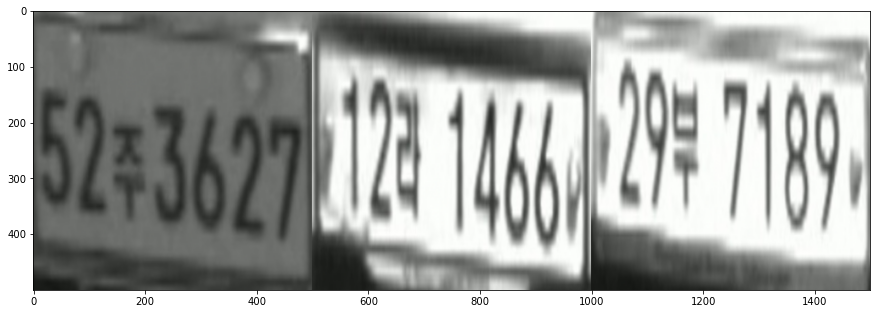

In [115]:
x_sample_concat = np.concatenate((x_sampled_img[:10]), axis=1)
plt.figure(figsize=(15,10))
plt.imshow(x_sample_concat)

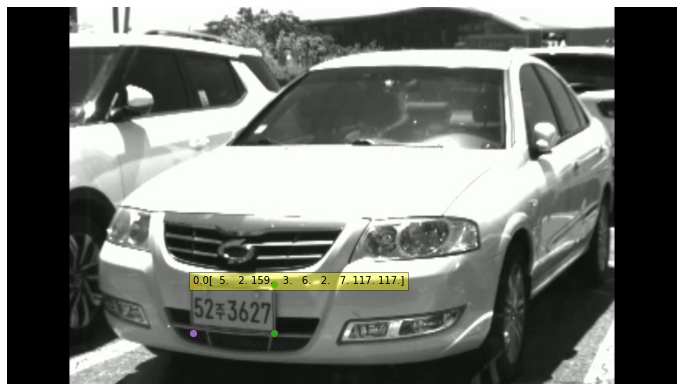

In [116]:
ax = visualize_plate(x_list[0], y_list[0])